In [15]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')
import lime

In [2]:
df = pd.read_csv("../data/hepatotoxicity_ALT_KlekFP_preprocessing_and_analyst.csv", header=0, index_col=False)

In [3]:
columns = list(df.columns.values)
columns.remove('ALT')

In [4]:
X = df[columns].values
y = df['ALT'].values

In [5]:
print(y)

[3.51452607 3.64283552 1.36609165 1.42551507 3.80888225 3.78895101
 3.61091791 3.16968558 3.33576958 3.60821155 3.83514196 3.37073817
 3.71357207 4.39444915 5.61312811 3.36729583 3.67882912 5.51544285
 5.5683445  4.06044301 3.31054301 3.25809654 3.4657359  3.91202301
 3.49650756 3.36729583 3.8286414  3.55534806 3.55534806 3.78418963
 3.73766962 4.2341065  3.72810017 4.1293899  3.4339872  1.18478998
 0.92028275 1.0612565  4.21360798 3.5204608  4.11087386 3.49650756
 4.12713439 3.80666249 5.3981627  3.16547505 3.29583687 3.91202301
 3.47815842 3.71357207 3.04452244 3.25809654 4.17438727 3.91202301
 4.32941668 3.52636052 3.56671182 3.62966009 3.53805656 4.03777421
 3.65842025 3.81109709 3.11794991 3.62700405 3.58629287 3.4657359
 3.61091791 3.93182563 3.40119738 4.06044301 3.58351894 3.91202301
 4.17438727 3.75887183 3.78872479 3.69635147 3.25809654 3.46260601
 3.4339872  3.04452244 3.83514196 3.42426265 3.59731226 3.19047635
 4.17438727 3.40119738 2.89037176 3.91202301 3.04452244 4.17438

In [6]:
print(X)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
models=[SGDRegressor(), SVR(), LinearRegression(), Lasso()]
params=[
    {'alpha' : [0.0, 0.01, 0.001, 0.0001, 0.00001],'learning_rate' : ['constant','optimal','invscaling'], 'random_state': [12345, 123, 666, 123123, 777, 69]},
    {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.], 'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},
    {},
    {'alpha':[0.001, 0.005, 0.01,0.05,0.1,0.5,1], 'random_state': [12345, 123, 666, 123123, 777, 69]}
]

In [8]:
best_results=[]
kfold = KFold(n_splits=5, random_state=2652124, shuffle=True)
for model, grid_params, in zip(models, params):
    results=[]
    cv_results=pd.DataFrame()
    for idx, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        repeatedKfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2652124)
        grid_search=GridSearchCV(estimator=model,param_grid=grid_params,scoring='r2',cv=repeatedKfold)
        grid_fit=grid_search.fit(X_train, y_train)
        results.append((grid_fit.best_estimator_, grid_fit.best_params_, grid_fit.best_score_))
        cv_result=pd.DataFrame(grid_search.cv_results_)
        cv_results=cv_results.append(cv_result, ignore_index=True)
    
    cv_results.to_csv("../data/models/" + str(model).strip("()") + ".csv", encoding='utf-8', header=True)
    
    res=pd.DataFrame(results, columns=['Model', 'Params','r2'])
    res=res.sort_values(by='r2').reset_index(drop=True)
    best=res.iloc[0]
    
    reg=best.Model
    reg.fit(X_train, y_train)
    Y_pred=reg.predict(X_test)

    mse=mean_squared_error(y_test, Y_pred)
    r2=r2_score(y_test, Y_pred)
    mae=mean_absolute_error(y_test, Y_pred)
    
    best_results.append({'Model' : reg, 'Params' : str(best.Params), 'MSE': mse, 'MAE': mae, 'R2' : r2})

    results=[]

In [9]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026175,0.020865,0.000000,0.000000,0.001,12345,"{'alpha': 0.001, 'random_state': 12345}",0.052402,-0.025968,0.899749,0.541398,-2.634841,0.073351,-0.429653,0.693136,0.092842,0.879649,0.014207,0.974642,25
1,0.021587,0.012178,0.000000,0.000000,0.001,123,"{'alpha': 0.001, 'random_state': 123}",0.052402,-0.025968,0.899749,0.541398,-2.634841,0.073351,-0.429653,0.693136,0.092842,0.879649,0.014207,0.974642,25
2,0.021096,0.007922,0.000000,0.000000,0.001,666,"{'alpha': 0.001, 'random_state': 666}",0.052402,-0.025968,0.899749,0.541398,-2.634841,0.073351,-0.429653,0.693136,0.092842,0.879649,0.014207,0.974642,25
3,0.030152,0.031372,0.001007,0.002426,0.001,123123,"{'alpha': 0.001, 'random_state': 123123}",0.052402,-0.025968,0.899749,0.541398,-2.634841,0.073351,-0.429653,0.693136,0.092842,0.879649,0.014207,0.974642,25
4,0.021118,0.009477,0.000000,0.000000,0.001,777,"{'alpha': 0.001, 'random_state': 777}",0.052402,-0.025968,0.899749,0.541398,-2.634841,0.073351,-0.429653,0.693136,0.092842,0.879649,0.014207,0.974642,25


In [10]:
best_model=pd.DataFrame(best_results)
best_model=best_model.sort_values(by='R2', ascending=False).reset_index(drop=True)
best_model

,Model,Params,MSE,MAE,R2
0,"SVR(C=25.0, coef0=0.01, gamma='auto', kernel='...","{'C': 25.0, 'coef0': 0.01, 'degree': 3, 'gamma...",1.766947e-01,2.909806e-01,7.107563e-01
1,"Lasso(alpha=0.005, random_state=12345)","{'alpha': 0.005, 'random_state': 12345}",3.402755e-01,3.527977e-01,4.429798e-01
2,"SGDRegressor(alpha=0.0, random_state=12345)","{'alpha': 0.0, 'learning_rate': 'invscaling', ...",3.518571e-01,3.592777e-01,4.240212e-01
3,LinearRegression(),{},3.203271e+26,5.347826e+12,-5.243653e+26


In [11]:
best_model.to_csv("../data/best_models/best_models_df.csv", encoding='utf-8', header=True)

In [12]:
for idx in range(0,4):
    model=best_model.iloc[idx].Model
    with open('../data/best_models/' + str(models[idx]).strip("()") + '.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print a == b

In [26]:
lr = best_model.iloc[0].Model
lr.fit(X_train, y_train)

print("Test R^2 Score  : ", lr.score(X_test, y_test))
print("Train R^2 Score : ", lr.score(X_train, y_train))

Test R^2 Score  :  0.7107563375801872
Train R^2 Score :  0.80431170758312


In [110]:
Y_pred=lr.predict(X_test)

In [128]:
Y_pred

array([3.63542411, 3.37743195, 5.47023909, 3.71084598, 3.42862763,
       4.07157532, 3.52342342, 2.56294602, 3.59995636, 3.52968298,
       3.46926164, 4.00920316, 3.8161636 , 3.63542411, 3.68262377,
       3.68297807, 3.42862763, 3.61451056, 3.71342983])

In [134]:
import numpy as np
x=np.arange(start=0, stop=len(y_test))

(19,)

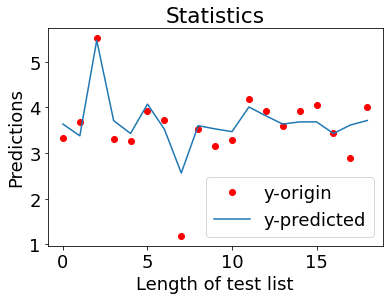

In [154]:
plt.plot(x, y_test, 'ro', label="y-origin")
plt.plot(x, Y_pred, label="y-predicted")
plt.title("Statistics")
plt.xlabel("Length of test list")
plt.ylabel("Predictions")
plt.legend(loc="lower right")

In [84]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train, mode="regression", feature_names= df.columns.values)
explainer

In [85]:
import random

idx = random.randint(1, len(X_test))

print("Prediction : ", lr.predict(X_test[idx].reshape(1,-1)))
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(X_test[idx], lr.predict, num_features=len(df.columns.values))
explanation

Prediction :  [3.46926164]
Actual :      3.295836866004329


In [86]:
explanation.show_in_notebook()


In [90]:
explanation.as_list()


[('KRFP1707 > 0.00', -0.11176341138283388),
 ('KRFP4142 <= 0.00', 0.09187569840554659),
 ('KRFP3806 <= 0.00', 0.09173840953657585),
 ('KRFP2716 <= 0.00', 0.09152277127301331),
 ('KRFP3809 <= 0.00', 0.09146913570739554),
 ('KRFP139 <= 0.00', 0.09143879206670542),
 ('KRFP4295 <= 0.00', 0.09119058587213004),
 ('KRFP4852 <= 0.00', 0.09097201372446503),
 ('KRFP3010 <= 0.00', 0.09086203252545207),
 ('KRFP3520 <= 0.00', 0.09080922946457058),
 ('KRFP2856 <= 0.00', 0.09068652365464146),
 ('KRFP4843 <= 0.00', 0.09064759829091763),
 ('KRFP4015 <= 0.00', 0.09047338699705075),
 ('KRFP4836 <= 0.00', 0.09023230482709106),
 ('KRFP4205 <= 0.00', 0.0898180816031861),
 ('KRFP2988 <= 0.00', 0.08966662675427822),
 ('KRFP582 <= 0.00', 0.08898947563859827),
 ('KRFP592 > 0.00', 0.08897477506843034),
 ('KRFP493 <= 0.00', -0.07966649133582895),
 ('KRFP2711 > 0.00', 0.0792044333148686),
 ('KRFP608 <= 0.00', 0.07782049923123951),
 ('KRFP3887 <= 0.00', 0.07727197403594038),
 ('KRFP2264 <= 0.00', 0.0772571308398075

In [108]:
explanation.save_to_file("../explanations/classif_explanation.html")

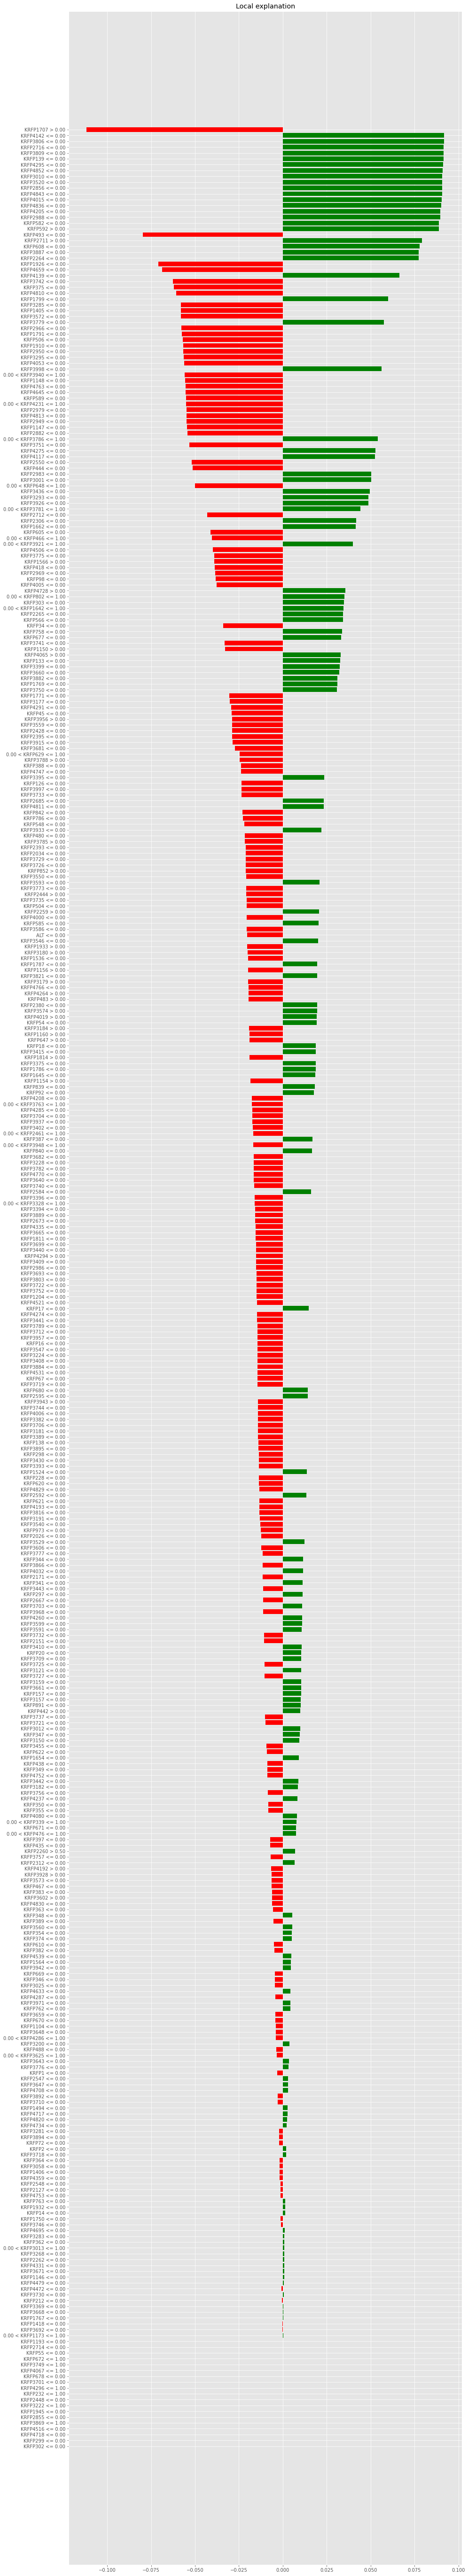

In [109]:
from matplotlib import pyplot as plt

with plt.style.context("ggplot"):
#         explanation.as_pyplot_figure().set_figheight(100).set_figwidth(80)
    fig=explanation.as_pyplot_figure().set_size_inches(15, 100)
    plt.savefig('../explanations/classif_explanation.png')

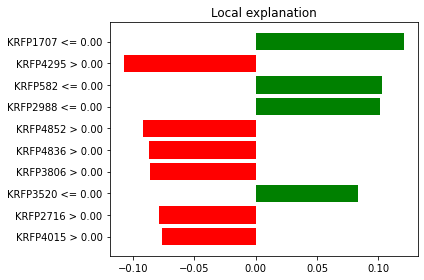

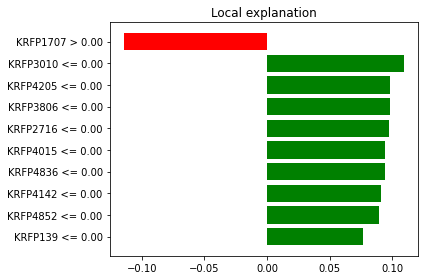

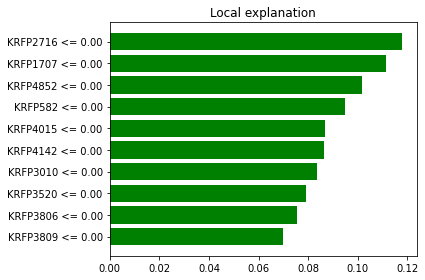

In [77]:
for i in [7, 10, 18]:
    exp = explainer.explain_instance(X_test[i], lr.predict,
            num_features=10)
    exp.as_pyplot_figure()
    plt.tight_layout()

In [55]:
explanation.as_list()


[('KRFP1707 <= 0.00', 0.11183399587566849),
 ('KRFP4843 <= 0.00', 0.09228545822974418),
 ('KRFP3010 <= 0.00', 0.09140639349186716),
 ('KRFP4295 <= 0.00', 0.09115724137637217),
 ('KRFP2856 <= 0.00', 0.0909972069548432),
 ('KRFP4852 <= 0.00', 0.09083628385023505),
 ('KRFP3520 <= 0.00', 0.09075337561331796),
 ('KRFP4015 <= 0.00', 0.09063581964165868),
 ('KRFP4142 <= 0.00', 0.09059794246128666),
 ('KRFP139 <= 0.00', 0.090574811178169),
 ('KRFP3809 <= 0.00', 0.09039404190132437),
 ('KRFP2988 <= 0.00', 0.09036964377910532),
 ('KRFP582 <= 0.00', 0.09033332495912551),
 ('KRFP3806 <= 0.00', 0.08988176261217544),
 ('KRFP2716 <= 0.00', 0.08986561291995675),
 ('KRFP4205 <= 0.00', 0.08961618003223887),
 ('KRFP4836 <= 0.00', 0.08957717135411003),
 ('KRFP592 <= 0.00', -0.08835655795688031),
 ('KRFP493 <= 0.00', -0.07896895316104767),
 ('KRFP2711 <= 0.00', -0.07863227590433958),
 ('KRFP3887 <= 0.00', 0.07835021771382882),
 ('KRFP2264 <= 0.00', 0.07775534510565547),
 ('KRFP608 <= 0.00', 0.0762482816252

,0
0,3.335770
1,3.678829
2,5.515443
3,3.310543
4,3.258097
5,3.912023
6,3.728100
7,1.184790
8,3.520461
9,3.165475
